# Background Methods

In [1]:
import traceback
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from WF_SDK import device
from WF_SDK import scope
from WF_SDK import wavegen

%matplotlib inline

In [2]:
class ADSHardware():
    """Class of functions for interfacing with the ADS.
    """

    def __init__(self):
        self.handle = None

    def startup(self):
        """Connects to the ADS. Defines 'handle', the address to the ADS.
        Must be run at the beginning of every program using the ADS.
        """
        self.handle = device.open()

    def open_scope(self, buffer_size=1000, sample_freq=100e6):
        """Opens connection to the scope.

        Args:
            buffer_size (int, optional): How many data points are temporarily stored
            before being returned. The buffer is a temporary slot for storing a small amount of
            data before it is transferred to its final destination. Defaults to 1000.
            sample_freq (int, optional): How frequently the oscilloscope will sample
            from the input. Defaults to 100e6. You can decrease this if you have too
            many data points/the function is taking awhile to run for the time scale you need.
            (1e6 or even 16e3 can be reasonable selections.)
        """
        scope.open(self.handle, buffer_size=buffer_size, sampling_frequency=sample_freq)

    def trigger_scope(self, channel=1, level=0.1):
        """Sets trigger level for the scope. Kind of a buggy function; not used.

        Args:
            channel (int, optional): Selects which channel of scope to read out. 
            Defaults to 1.
            level (float, optional): Sets trigger level for scope. Defaults to 0.1.
        """
        scope.trigger(self.handle, enable=True, source=scope.trigger_source.analog, channel=channel,
                      edge_rising=True, level=level)

    def read_scope(self, channel=1):
        """Collects data from the scope.

        Args:
            channel (int, optional): Which channel to read from. Defaults to 1.

        Returns:
            buffer (array): An array of output data points. The buffer is a temporary slot 
            for storing a small amount of data before it is transferred to its final destination.
        """
        buffer = scope.record(self.handle, channel=channel)
        return buffer

    def close_scope(self):
        """Closes connection to the scope.
        """
        scope.close(self.handle)

    def use_wavegen(self, channel=1, function=wavegen.function.sine, offset_v=0, freq_hz=1e3, amp_v=1):
        """Runs the wavegen producing function with given parameters.

        Args:
            channel (int, optional): Which channel output is at. Defaults to 1.
            function (function object, optional): What type of function to output. 
            Defaults to wavegen.function.sine.
            offset (int, optional): Voltage offset (V). Defaults to 0.
            freq (int, optional): Frequency (Hz). Defaults to 1e3.
            amp (int, optional): Amplitude (V). Defaults to 1.
        """
        wavegen.generate(self.handle, channel=channel, function=function, offset=offset_v,
                         frequency=freq_hz, amplitude=amp_v)

    def close_wavegen(self):
        """Closes wavegen.
        """
        wavegen.close(self.handle)

    def disconnect(self):
        """Closes ADS connection. Must be run at the end of every program.
        """
        device.close(self.handle)

In [3]:
def oscilloscope_run(ads_object: ADSHardware, duration: float, channel: int, sampling_freq=400000):
    """Collects data from the oscilloscope.

    Args:
        ads_object (ADSHardware object): the ADS being used
        duration (int): time length of trace to collect in seconds
        channel (int): which channel to collect data from
        sampling_freq (int, optional): How frequently the oscilloscope will sample (Hz)
        from the input. Defaults to 1e6. You can decrease this if you have too
        many data points/the function is taking awhile to run for the time scale you need.
        (16e3 can be a reasonable selection.)

    Returns:
        data (dict): has two keys, "x" and "y" which have time (ms) and voltage (V) data
    """
    buffer_size = int(duration * sampling_freq)
    data = {}
    ads_object.open_scope(sample_freq=sampling_freq, buffer_size=buffer_size)

    MS_CONVERSION = 1e3

    buffer = ads_object.read_scope(channel=channel)
    data["y"] = buffer

    #MODIFY THE LINE BELOW THIS ONE IN L10.2(d)
    data["x"] = np.arange(buffer_size) / sampling_freq * MS_CONVERSION
    
    ads_object.close_scope()
    return data

In [10]:
wavegen_functions = {"sine":wavegen.function.sine, "square":wavegen.function.square,
                     "triangle":wavegen.function.triangle, "dc":wavegen.function.dc, "pulse": wavegen.function.pulse}

# Sonar

In [5]:
ads = ADSHardware()
ads.startup()

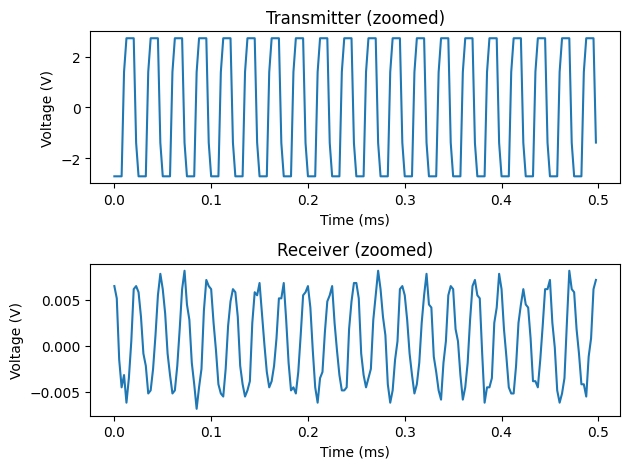

In [7]:
freq  = 40e3
Amp   = 2
pulse = 0.02

ads.use_wavegen(channel=1, function=wavegen_functions["sine"], offset_v=0, freq_hz=freq, amp_v=Amp)

sampling_rate = 400000

tx_data = oscilloscope_run(ads, pulse, 1, sampling_freq=sampling_rate)   # transmitter
rx_data = oscilloscope_run(ads, pulse, 2, sampling_freq=sampling_rate)   # receiver

ads.close_wavegen()

t_tx = np.array(tx_data["x"])
v_tx = np.array(tx_data["y"])
t_rx = np.array(rx_data["x"])
v_rx = np.array(rx_data["y"])

# Zoom window (0–0.5 ms)
mask_tx = t_tx < 0.5    # ms
mask_rx = t_rx < 0.5

plt.figure()
plt.subplot(2,1,1)
plt.plot(t_tx[mask_tx], v_tx[mask_tx])
plt.title("Transmitter (zoomed)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")

plt.subplot(2,1,2)
plt.plot(t_rx[mask_rx], v_rx[mask_rx])
plt.title("Receiver (zoomed)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")

plt.tight_layout()
plt.show()

In [8]:
# Now let's try sending a pulse instead of a continuous wave
# Redefine the oscilloscope_run() function

def oscilloscope_run_two(ads_object: ADSHardware,
                         duration: float,
                         sampling_freq: int = 400_000):
    """
    Collects data from BOTH oscilloscope channels in one acquisition.

    Returns:
        data (dict): keys "t_ms", "ch1", "ch2"
    """
    buffer_size = int(duration * sampling_freq)

    # You may need to add a 'channels' or similar argument depending on your ADSHardware
    ads_object.open_scope(sample_freq=sampling_freq, buffer_size=buffer_size)

    MS_CONVERSION = 1e3

    # This part depends on how ADSHardware is written.
    # If read_scope returns a 2D array [ch][samples], keep it as is.
    # If it only returns one channel, you’ll need a different method from your lab
    # that returns both, e.g. ads_object.read_scope_both().
    # I’ll assume it returns a 2D array: buffer[0] = CH1, buffer[1] = CH2.
    buffer = ads_object.read_scope()
    ch1 = np.array(buffer[0])
    ch2 = np.array(buffer[1])

    t_ms = np.arange(buffer_size) / sampling_freq * MS_CONVERSION

    ads_object.close_scope()

    return {"t_ms": t_ms, "ch1": ch1, "ch2": ch2}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

SOUND_SPEED = 343.0  # m/s

# --- Sonar parameters ---
freq          = 40e3          # 40 kHz
cycles        = 40            # number of cycles in the burst
burst_T       = cycles / freq # burst duration (s) ~1 ms for 40 cycles
capture_T     = 0.02          # total capture window (s) -> 20 ms
sampling_rate = 400_000       # 400 kHz, fits 20 ms in 8k samples
Amp           = 2.0           # V amplitude at AWG

# 1) Configure wavegen for a BURST instead of continuous
# This assumes ADSHardware has some way to expose WF_SDK.wavegen.generate().
# If not, you or the GSI can add a method like `use_wavegen_burst(...)` that wraps it.
#
# Pseudocode for that inside ADSHardware would be something like:
# wavegen.generate(self.device, channel=1, function=wavegen.function.sine,
#                  frequency=freq, amplitude=Amp, offset=0,
#                  run_time=burst_T, wait=0.0, repeat=1)

ads.use_wavegen(  # <-- you will need to implement this wrapper in ADSHardware
    channel=1,
    function=wavegen_functions["pulse"],
    offset_v=0,
    freq_hz=freq,
    amp_v=Amp,
)

# 2) Arm the scope and record BOTH channels during the ping + echo
data = oscilloscope_run_two(ads, duration=capture_T, sampling_freq=sampling_rate)

t_ms = data["t_ms"]
tx_raw = data["ch1"]   # Tx probe
rx_raw = data["ch2"]   # Rx transducer

# 3) Optional: bandpass around 40 kHz to clean things up
low = 30e3
high = 50e3
b, a = sig.butter(4, [low, high], btype='bandpass', fs=sampling_rate)
tx = sig.filtfilt(b, a, tx_raw)
rx = sig.filtfilt(b, a, rx_raw)

# 4) Cross-correlate Rx with Tx to find delay
corr = sig.correlate(rx, tx, mode="full")
lags = sig.correlation_lags(len(rx), len(tx), mode="full")
idx_max = np.argmax(np.abs(corr))
lag_samples = lags[idx_max]
dt = lag_samples / sampling_rate  # seconds

# 5) Convert to distance (Tx & Rx close together)
distance = 0.5 * SOUND_SPEED * dt

print(f"Estimated time delay Δt ≈ {dt*1e3:.3f} ms")
print(f"Estimated distance     ≈ {distance:.3f} m")

# 6) Plot for sanity check (zoomed on the burst region)
mask = (t_ms > 0) & (t_ms < 5)  # 0–5 ms region; tweak as needed

plt.figure()
plt.subplot(2,1,1)
plt.plot(t_ms[mask], tx[mask])
plt.title("Tx burst (filtered)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")

plt.subplot(2,1,2)
plt.plot(t_ms[mask], rx[mask])
plt.title("Rx signal (filtered)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (V)")

plt.tight_layout()
plt.show()
